In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

## Part 1 -- Data

In [2]:
dir_data = '/home/hhg/Research/emu_Nx2pt/data/'
filename = dir_data+'pco_train_300.pkl'

with open(filename, 'rb') as handle:
    pco_samples = pickle.load(handle)

df_pco = pd.DataFrame(pco_samples)
df_pco.head()

,Omega_m,sigma_8,Omega_b,n_s,h
0,0.279667,0.805917,0.043507,1.043000,0.707000
1,0.310333,0.817583,0.045507,0.979000,0.739667
2,0.354333,0.813750,0.048333,0.963000,0.741000
3,0.393000,0.824750,0.049800,0.904333,0.601000
4,0.311000,0.846750,0.042653,0.941000,0.727000


In [3]:
Nsamples = len(pco_samples['Omega_m'])
sampleID = list(range(Nsamples))

trainID, validID = train_test_split(sampleID, train_size=0.7, random_state=0)

In [4]:
class datavDataset(Dataset):
    
    def __init__(self, IDs, df_pco, dir_datav, Nout=1375, transform=None):
        self.IDs = IDs
        self.dir_datav = dir_datav
        self.df_pco = df_pco
        self.Nout = Nout
        
    def __getitem__(self, index):
        pcoID = self.IDs[index]
        datav = torch.from_numpy(np.loadtxt( os.path.join(self.dir_datav, '10x2pt_emu_'+str(pcoID)) )[:,1][0:self.Nout]).float()
        pco = torch.from_numpy(df_pco.iloc[[pcoID]].values[0]).float()
        
        return pco, datav
    
    def __len__(self):
        return len(self.IDs)

In [5]:
dir_datav = '/home/hhg/Research/emu_Nx2pt/data/train_300/'

train_dataset = datavDataset(trainID, df_pco, dir_datav)
valid_dataset = datavDataset(validID, df_pco, dir_datav)

In [6]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

## Part 2 -- Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Device configuration 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Npco = 5
Nhidden1 = 20
Nhidden2 = 50
Nout = train_dataset.Nout

class SimpleNet(nn.Module):
    
    def __init__(self, Npco, Nout, Nhidden1, Nhidden2):
        super().__init__()
        self.fc1 = nn.Linear(in_features=Npco, out_features=Nhidden1)
        self.fc2 = nn.Linear(in_features=Nhidden1, out_features=Nhidden2)
        self.fc3 = nn.Linear(in_features=Nhidden2, out_features=Nout)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
# Hyper-parameters
num_epochs = 30
batch_size = batch_size
learning_rate = 0.001

########################

model = SimpleNet(Npco=Npco, Nout=Nout, Nhidden1=Nhidden1, Nhidden2=Nhidden2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
### define training loop ### 

n_iters_1epoch = len(train_loader)

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Step [{i+1}/{n_iters_1epoch}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [1/30] Step [10/14], Loss: 0.0058
Epoch [2/30] Step [10/14], Loss: 0.0017
Epoch [3/30] Step [10/14], Loss: 0.0004
Epoch [4/30] Step [10/14], Loss: 0.0001
Epoch [5/30] Step [10/14], Loss: 0.0000
Epoch [6/30] Step [10/14], Loss: 0.0000
Epoch [7/30] Step [10/14], Loss: 0.0000
Epoch [8/30] Step [10/14], Loss: 0.0000
Epoch [9/30] Step [10/14], Loss: 0.0000
Epoch [10/30] Step [10/14], Loss: 0.0000
Epoch [11/30] Step [10/14], Loss: 0.0000
Epoch [12/30] Step [10/14], Loss: 0.0000
Epoch [13/30] Step [10/14], Loss: 0.0000
Epoch [14/30] Step [10/14], Loss: 0.0000
Epoch [15/30] Step [10/14], Loss: 0.0000
Epoch [16/30] Step [10/14], Loss: 0.0000
Epoch [17/30] Step [10/14], Loss: 0.0000
Epoch [18/30] Step [10/14], Loss: 0.0000
Epoch [19/30] Step [10/14], Loss: 0.0000
Epoch [20/30] Step [10/14], Loss: 0.0000
Epoch [21/30] Step [10/14], Loss: 0.0000
Epoch [22/30] Step [10/14], Loss: 0.0000
Epoch [23/30] Step [10/14], Loss: 0.0000
Epoch [24/30] Step [10/14], Loss: 0.0000
Epoch [25/30] Step [10/14

## Part 3 -- Validate Model

In [20]:
validSamples = iter(valid_loader)

In [21]:
with torch.no_grad():
    pco, datav = validSamples.next()
    
    pco = pco.to(device)
    datav = datav.to(device)
    
    predict = model(pco)

predict = predict.to('cpu').numpy()
datav = datav.to('cpu').numpy()

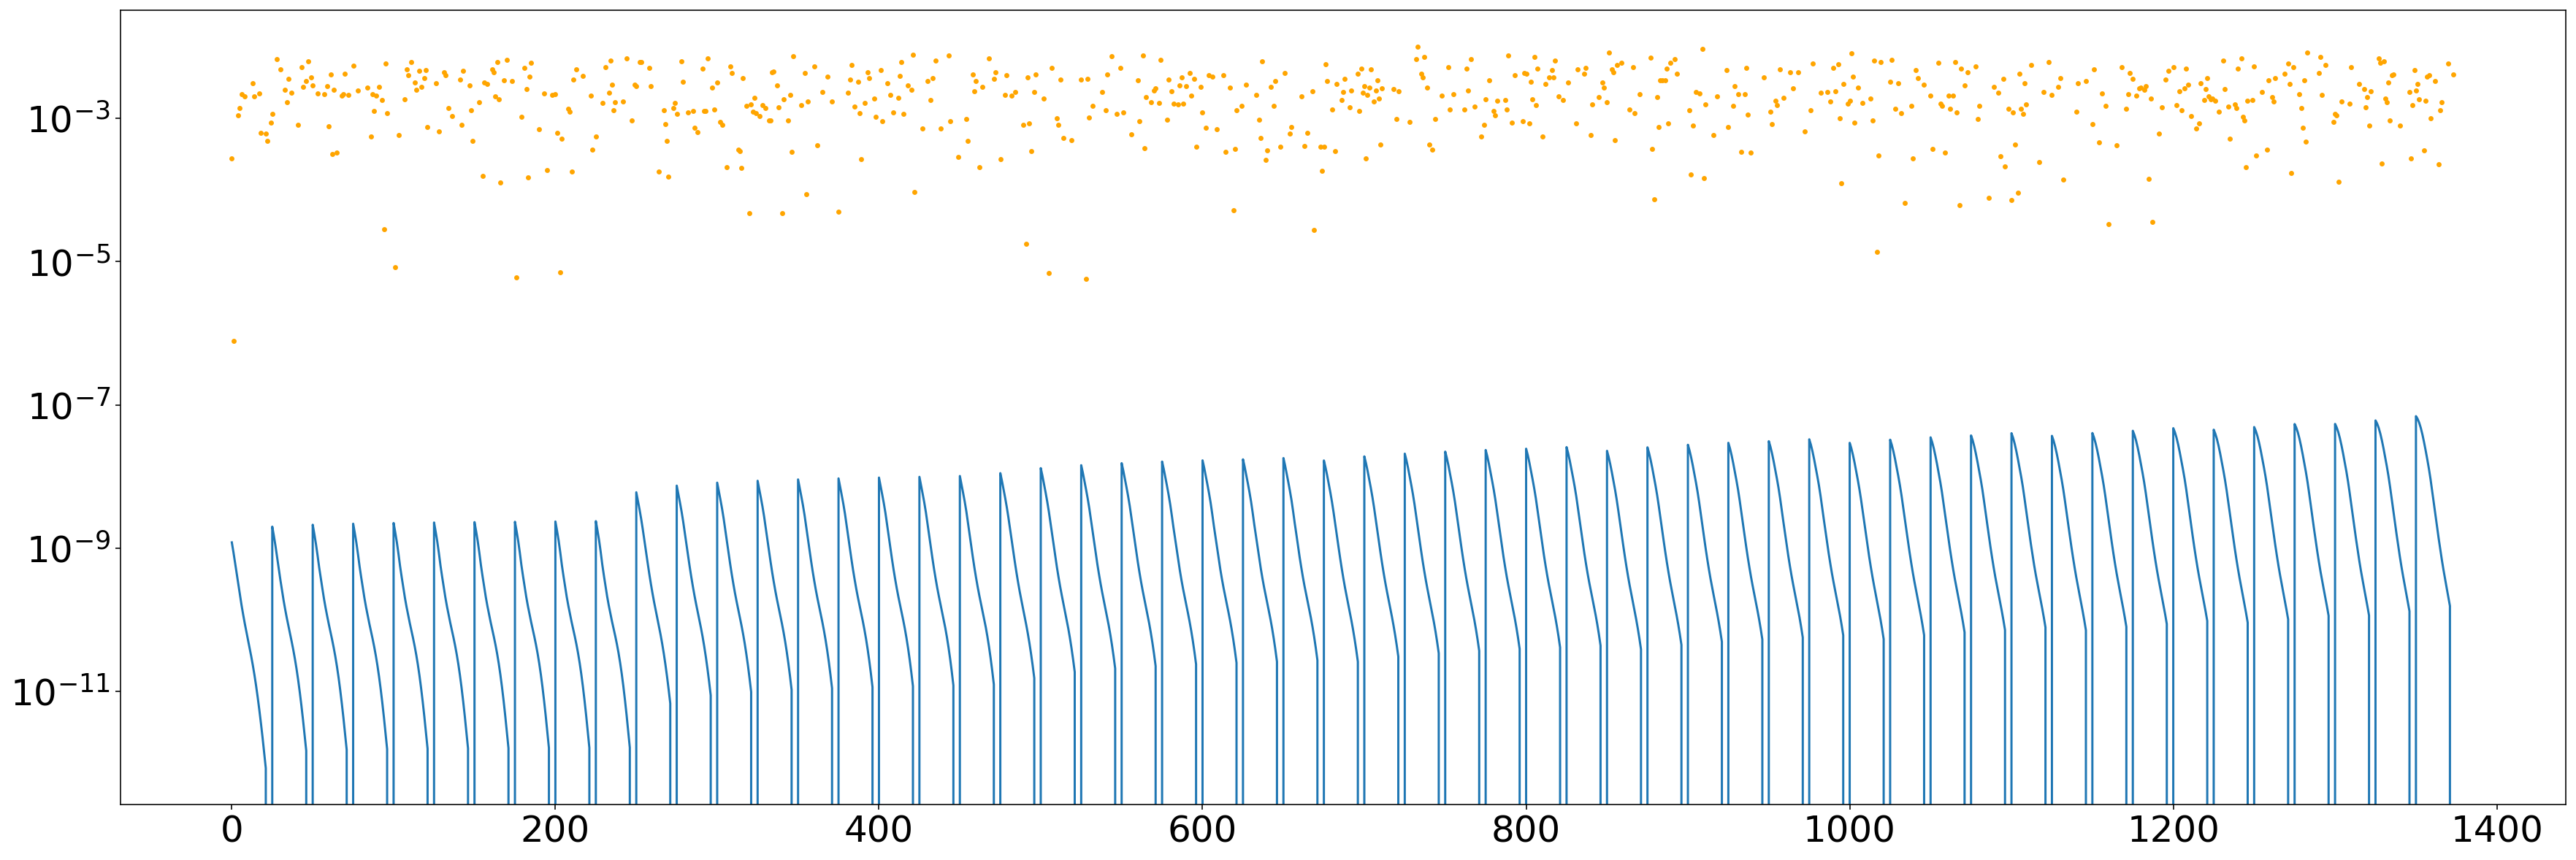

In [29]:
batchID = 1

plt.subplots(figsize=(30, 10))
plt.plot(range(0,len(datav[batchID])), datav[batchID])
plt.scatter(range(0,len(datav[batchID])), predict[batchID], s=6, color='orange')
plt.yscale('log')
plt.tick_params(axis='both', labelsize=25)

In [30]:
datav

array([[2.989304e-09, 2.394481e-09, 1.869259e-09, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.208745e-09, 8.833739e-10, 6.292681e-10, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.927646e-09, 2.237637e-09, 1.668983e-09, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [2.721906e-09, 2.084322e-09, 1.557837e-09, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.113917e-09, 1.611762e-09, 1.197677e-09, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.721990e-09, 1.268187e-09, 9.108021e-10, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]], dtype=float32)